<h2> Spectroscopic data reduction : spectra module

<h3> ARCES : echelle spectroscopy

In [1]:
from pyvista import imred, tv, spectra
import numpy as np
import matplotlib.pyplot as plt

pyvista uses a display tool defined in the tv module. To use the interactive
display in a notebook, set the display to be an external display window, e.g. with 
<code>
%matplotlib qt
</code>
Instantiate a tv object, here we just call it t, but you could call it whatever you want!
<p>
The display tools supports a number of "asynchronous" operations, e.g. zoom and pan with the mouse buttons, etc. Enter a '?' in the display window to see a list.

In [2]:
# Use these lines if you are running the notebook yourself. Matplotlib
# window will open outside the notebook, which is the desired behavior so
# you can have a single display tool, which you should leave open. Other
# plot windows will also appear outside the notebook, which you can close
# as desired
%matplotlib qt
t=tv.TV()
plotinter=True

# following lines only for fully noninteractive demo of notebook, to allow
#    inline demo of plots (but not image display)
#%matplotlib inline
#t=None
#plotinter=False     # normally, want this to be True 

The basic tool for basic image reduction is a Reducer object, defined in the imred module. Instantiate a reducer here. The main argument is an instrument name, which tells it to read a YAML configuration file for the specified instrument. We also give it an optional dir= argument to specify the default directory from which to read images, if a directory is not specified in subsequent commands that read images.

In [3]:
red=imred.Reducer('ARCES',dir='/home/holtz/red/UT211031/echelle')

INSTRUMENT: ARCES   config: 
  will use format:  /home/holtz/red/UT211031/echelle/*{:04d}.f*.fits*
         gain:  [3.8]    rn: [ 7.]
         scale:  None   
  Biastype : 0
  Bias box: 
    SC    NC    SR    NR
  2075    51    20  2009 
  Trim box: 
    SC    NC    SR    NR
    22  2026     0  2048 
  Norm box: 
    SC    NC    SR    NR
  1000    51  1000    51 


A main method of the reducer object is the reduce() method. Without any additional arguments, reduce() will read an image from disk, subtract the overscan (region(s) as determined from the instrument configuration file), compute an uncertainty array using the gain and readout noise from the instrument configuration file, and return a pyvista Data object with the data, uncertainty, and mask in different attributes.
<p>
To specify the input image, we could pass a string with the file name. If the string does not include a '/', it will read from the default input directory.
<p>
If the file can be identified with a unique integer, then you can just specify this number, which can be very convenient. This is turned into a character string using the formstr attribute define in the configuration file, which is used to search for the file to read.
<p>
Note that the default for reduce() is to trim the image, removing over/underscan as specified in the instrument configuration file. If you specify trim=False, then these regions will be preserved.
    
<p>
We can display the image using the tv() method of our display tool, which can take as input a Data object, and numpy array, or a FITS HDU object.

In [4]:
red.log(htmlfile='log.html').show_in_notebook(display_length=10)

idx,FILE,DATE-OBS,OBJNAME,RA,DEC,EXPTIME
0,ThAr.0001.fits,2021-10-30T23:08:48.959,,6:56:00.00,10:00:00.00,29.999639034271
1,ThAr.0002.fits,2021-10-30T23:11:52.822,,6:56:00.00,10:00:00.00,30.000228881836
2,ThAr.0003.fits,2021-10-30T23:14:57.305,,6:56:00.00,10:00:00.00,30.000248908997
3,ThAr.0004.fits,2021-10-30T23:18:01.781,,6:56:00.00,10:00:00.00,29.999611854553
4,flat_red.0005.fits,2021-10-30T23:21:06.521,,6:56:00.00,10:00:00.00,6.9998741149902
5,flat_red.0006.fits,2021-10-30T23:23:48.699,,6:56:00.00,10:00:00.00,6.9998621940613
6,flat_red.0007.fits,2021-10-30T23:26:29.657,,6:56:00.00,10:00:00.00,6.9998688697815
7,flat_red.0008.fits,2021-10-30T23:29:11.599,,6:56:00.00,10:00:00.00,6.9998691082001
8,flat_red.0009.fits,2021-10-30T23:31:53.347,,6:56:00.00,10:00:00.00,6.9998760223389
9,flat_red.0010.fits,2021-10-30T23:34:35.149,,6:56:00.00,10:00:00.00,6.9998240470886


In [5]:
a=red.reduce(28)

if t is not None :
    t.tv(a)

  Reading file: /home/holtz/red/UT211031/echelle/HIP109807.0028.fits
  subtracting overscan:  1291.72
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


<h4> Calibration: make and apply flat field

If we add additional arguments to reduce(), we can add additional calibration steps. For example, to flat field the data, we would add a flat= keyword through which we give the reducer a flat field. To add a spatial bias subtraction, we would add a bias= keyword through which we give the reducer a superbias frame.
<br>
First, however, we have to make the calibration products, which is accomplished using the mkflat(), mkbias(), etc methods. These take as input a list of frames to be used to construct the master calibration frame (e.g.. superflat). For ARCES, we will keep the spectral shape of the flats for now.

Create biases and flats. Note that for flats, we have to do scattered light removal, which can be done on reduction of individual images, but since it is slow, we will do it on the combined flat. If we add the display= keyword, giving a display object, then the calibration frames will be displayed, showing each input frame relative to the master frame, so you can inspect and make sure that bad frames are not being included in the combination.

In [6]:
bias=red.mkbias([19,20,21,22,23,24])
flat_red=red.mkflat([5,6,7,8,9,10,11])
flat_blue=red.mkflat([12,13,14,15,16,17,18])

# do scatter after combination to save time
red.scatter(flat_red,scat=red.scat,display=t)
red.scatter(flat_blue,scat=red.scat,display=t)

  Reading file: /home/holtz/red/UT211031/echelle/bias.0019.fits
  subtracting overscan:  1288.79
  Reading file: /home/holtz/red/UT211031/echelle/bias.0020.fits
  subtracting overscan:  1288.58
  Reading file: /home/holtz/red/UT211031/echelle/bias.0021.fits
  subtracting overscan:  1288.52
  Reading file: /home/holtz/red/UT211031/echelle/bias.0022.fits
  subtracting overscan:  1288.55
  Reading file: /home/holtz/red/UT211031/echelle/bias.0023.fits
  subtracting overscan:  1288.97
  Reading file: /home/holtz/red/UT211031/echelle/bias.0024.fits
  subtracting overscan:  1289.03
  combining data with median....
  calculating uncertainty....
  Reading file: /home/holtz/red/UT211031/echelle/flat_red.0005.fits
  subtracting overscan:  1287.67
  Reading file: /home/holtz/red/UT211031/echelle/flat_red.0006.fits
  subtracting overscan:  1287.76
  Reading file: /home/holtz/red/UT211031/echelle/flat_red.0007.fits
  subtracting overscan:  1287.53
  Reading file: /home/holtz/red/UT211031/echelle/fla

Combine the red and blue flats. To do, we multiply each by the normalization factor used to create the flats, and then add them. We then display them with the tv tool. Note the last tv() command, which displays the S/N image (the data attribute divided by the uncertainty attribute of the pyvista Data object). You can cycle through these four images in the display tool, using the +/- keys to cycle forward and backward through the stack.

In [7]:
flat=flat_red.multiply(flat_red.header['MEANNORM'])
flat=flat.add(flat_blue.multiply(flat_blue.header['MEANNORM']))
flat=flat.divide(flat_red.header['MEANNORM']+flat_blue.header['MEANNORM'])
flat.add_bitmask(flat_red.bitmask | flat_blue.bitmask)
if t is not None :
    t.clear()
    t.tv(flat_blue)
    t.tv(flat_red)
    t.tv(flat)
    t.tv(flat,sn=True)

Read and display a star spectral image. For ARCES, we do not apply a flat field here, since we only have flats with the orders, which can move around a bit. Instead, we will use "1D" flats later in the processing. 

In [8]:
star=red.reduce(35,bias=bias)
if t is not None :
    t.tv(star,max=1000) 

  Reading file: /home/holtz/red/UT211031/echelle/HD16760.0035.fits
  subtracting overscan:  1291.73
  subtracting bias...
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


Cosmic ray rejection can be tricky. Here we use the LACosmic routine of van Dokkum, as implemented in the astroscrappy package. Alternatively, you can use a median filter rejection if you specify the shape of the filter in the crbox argument (e.g. crbox=[5,1] will median filter with a box 5 rows by one column, rejecting pixels greater than nsig times the estimate uncertainty.
<p>
With the display= keyword, the image before CR removal, after CR removal, and pixels identified as CRs are display in the specified display tool.
<p>
If the crbox= keyword is specified in reduce(), then the CR-rejection will happen as part of image reduction.

In [9]:
#crstar=red.crrej(star,crbox='lacosmic',display=t,objlim=50)
crstar=red.reduce(35,crbox='lacosmic',display=t,crsig=7,objlim=50,sigfrac=1.)

  Reading file: /home/holtz/red/UT211031/echelle/HD16760.0035.fits
  subtracting overscan:  1291.73
  zapping CRs with astroscrappy detect_cosmics
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


<h4> Tracing and extraction

To facilitate tracing, we can start from an existing set of traces for the instrument. We instantiate a Trace object using this previous set.

In [10]:
traces=spectra.Trace('ARCES/ARCES_traces.fits')
vars(traces)

no attribute:  rows


{'type': 'Polynomial1D',
 'degree': 2,
 'sc0': 1064,
 'pix0': -0.016310744310946035,
 'spectrum': array([  7.71968625e-04,   7.23036355e-04,   8.62288638e-04, ...,
          7.60172697e-05,   3.69138026e-04,   1.36280447e-04], dtype=float32),
 'rad': 5,
 'lags': array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9]),
 'transpose': False,
 'rows': None,
 'index': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 1

We can retrace a current frame using the initial guess. This is done by cross correlating a cross-section across traces with the reference frame, and using the shifted locations as a starting guess for the traces.
<p>
With the display= keyword, we will see the traces that it determined. Points are the centroids, and the line is the polynomial fit that defines the trace.
<p>
If you wanted to use a set of existing traces, but allow for a shift, the find() method will determine the shift, but not retrace.

In [11]:
traces.retrace(flat,display=t)

  Derived pixel shift from input trace:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift:  0.0450065159434
Using shift: 

/home/holtz/git/pyvista/python/pyvista/spectra.py:1126: RuntimeWarning: invalid value encountered in true_divide
  gd = np.where((~ymask) & (ysum/np.sqrt(yvar)>thresh) )[0]
/home/holtz/git/pyvista/python/pyvista/spectra.py:1137: RuntimeWarning: invalid value encountered in true_divide
  gd = np.where((~ymask) & (ysum/np.sqrt(yvar)>thresh) & (np.abs(res)<rad))[0]


  Tracing row: 1574


<Figure size 432x288 with 0 Axes>

In [12]:
vars(traces)

{'type': 'Polynomial1D',
 'degree': 2,
 'sc0': 1064,
 'pix0': 0,
 'spectrum': array([  7.51333137e-04,   7.00223667e-04,   8.37234315e-04, ...,
          4.74350200e-05,   3.41410167e-04,   1.09522814e-04], dtype=float32),
 'rad': 5,
 'lags': array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9]),
 'transpose': False,
 'rows': None,
 'index': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104

Sum up the arc lamp exposures, get the shift for the existing traces (but don't retrace, since we don't have a continuum), and extract. Note that if you have a multiprocessor machine, you can specify number of threads to use for the extraction, which will speed things up (but the default threads=0 isn't too terrible).
<p>
With the display= keyword, you will see the cross-correlation for find(), and will see the extraction windows for extract(); green lines show the traces, and blue and purple outline the extent of the extraction windows.

In [13]:
arc=red.sum([1,2,3,4],crbox=[5,1])
traces.find(arc,display=t)
arcec=traces.extract(arc,display=t,threads=0)

  Reading file: /home/holtz/red/UT211031/echelle/ThAr.0001.fits
  subtracting overscan:  1287.78
  Iteration 0, zapping CRs with filter [5,1]...
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Reading file: /home/holtz/red/UT211031/echelle/ThAr.0002.fits
  subtracting overscan:  1287.78
  Iteration 0, zapping CRs with filter [5,1]...
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Reading file: /home/holtz/red/UT211031/echelle/ThAr.0003.fits
  subtracting overscan:  1287.61
  Iteration 0, zapping CRs with filter [5,1]...
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Reading file: /home/holtz/red/UT211031/echelle/ThAr.0004.fits
  subtracting overscan:  1287.77
  Iteration 0, zapping CRs with filter [5,1]...
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  combining data with su

Do line identification based on previously identified lines, and wavelength fit. This is achieved by instantiated a WaveCal object using a previously determined object for ARCES. This saves positions and identifications of lines and, when instantiated, does an initial fit.

In [14]:
wav=spectra.WaveCal('ARCES/ARCES_wave.fits')
vars(wav)

  rms:    0.019
rejecting 90 points from 3653 total: 
  rms:    0.019
rejecting 90 points from 3653 total: 


{'type': 'chebyshev2D',
 'degree': 2,
 'ydegree': 3,
 'waves': array([ 10133.5662,   9833.4229,   9826.4492, ...,   3561.0304,
          3559.5081,   3545.5957]),
 'waves_order': array([ 56,  58,  58, ..., 160, 160, 160]),
 'orders': array([ 54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160]),
 'index': array([0]),
 'pix0': -5.1791778332699323e-07,
 'pix': array([  979.6753688 ,   582.69743052,   639.72191686, ...,   678.21538205,
          712.4360

The identify() method now uses the previous solution to identify lines on a new wavelength calibration image; this is done by first cross-correlting the image with an image saved in the WaveCal object. With plot=True, it will allow you to remove lines that are poorly fit.

  cross correlating with reference spectrum using lags:  range(-300, 300)
  Derived pixel shift from input wcal:  [-23.25182149]


/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:    0.028
rejecting 25 points from 2025 total: 
  rms:    0.012
rejecting 26 points from 2025 total: 
  rms:    0.012
rejecting 26 points from 2025 total: 
  See 2D wavecal fit. Enter space in plot window to continue



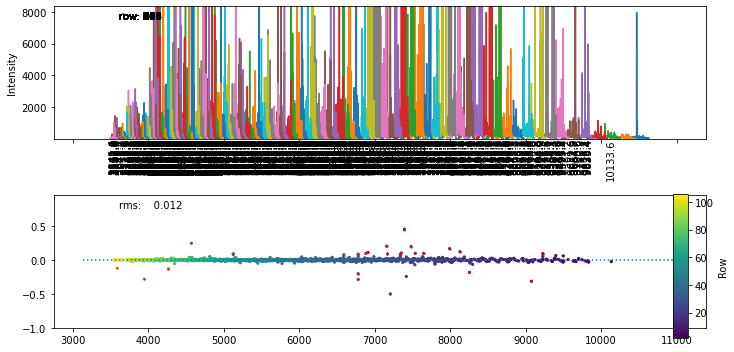

In [15]:
wav.identify(spectrum=arcec,rad=3,display=t,plot=True,plotinter=plotinter)

Now reduce an image

In [16]:
im=red.reduce(26,scat=red.scat,display=None)

  Reading file: /home/holtz/red/UT211031/echelle/HIP_9598.0026.fits
  subtracting overscan:  1290.08
  estimating scattered light ...
    fitting surface ...
    rejecting points ...
    refitting surface ...
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


In [17]:
if t is not None :
    t=tv.TV()
    t.tv(im)

Get shift of traces, and extract. Alternatively, you could use a single call to retrace(), which will do the find() and then trace() using the shifted stored model as a starting guess.

In [18]:
traces.find(im,display=t)
imec=traces.extract(im,display=t)

  Derived pixel shift from input trace:  0.540752432235
  extracting ... 



In [19]:
if t is not None :
    t.clear()
    t.tv(im)
    t.tv(imec)

Add the wavelengths for all pixels from the wavelength solution and plot extracted spectra.

(0.0, 67997.08334675654)

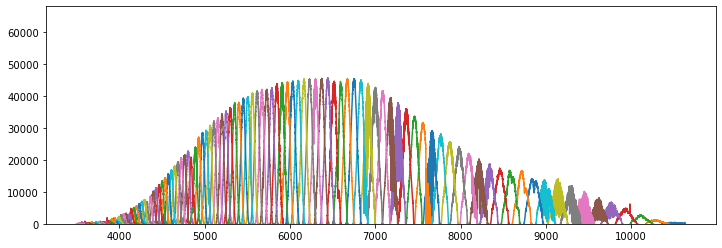

In [20]:
wav.add_wave(imec)
plt.figure(figsize=(12,4))
for row in range(len(imec.wave)) :
    plt.plot(imec.wave[row],imec.data[row])
from scipy.ndimage import median_filter
plt.ylim(0,median_filter(imec.data,[1,25]).max()*1.5)

Now create 1D flat field. 2D flat fielding would be better, but poses challenges with ARCES because the traces move, and there's no way to illuminate all pixels.

In [21]:
flat=red.trim(flat,trimimage=True)
traces.find(flat)
flat1d=traces.extract(flat)
if t is not None :
    t.tv(flat1d)

INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Derived pixel shift from input trace:  0.097649102629
  extracting ... 



In [22]:
if t is not None :
    t.tv(imec)

<h3> Combining orders </h3>

Resample onto logarithmic wavelength grid and combine orders

In [23]:
wnew=10**np.arange(3.5,4.0,5.5e-6)
starcomb=wav.scomb(imec,wnew,average=False,usemask=True)
flatcomb=wav.scomb(flat1d,wnew,average=False,usemask=True)

First, we sum the orders of the object, sum the orders of the 1d flat, and divide the two. Compare this with just summing the orders without flat fielding.

/tmp/ipykernel_42372/2071204533.py:9: RuntimeWarning: invalid value encountered in true_divide
  data=starcomb.data/flatcomb.data


(0.0, 1.5)

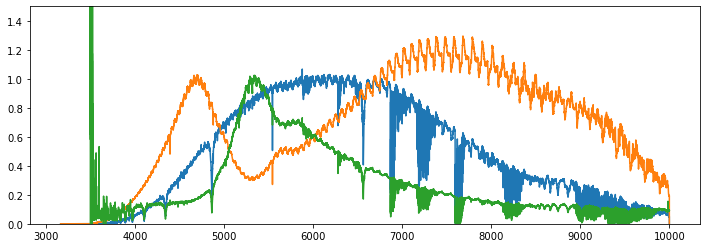

In [24]:
plt.figure(figsize=(12,4))
data=starcomb.data
plt.plot(wnew,data/np.nanmax(median_filter(data[20000:50000],[500])))
#flatcomb.data /= median_filter(flatcomb.data,[5000])

data=flatcomb.data
plt.plot(wnew,data/np.nanmax(median_filter(data[20000:50000],[500])))

data=starcomb.data/flatcomb.data
plt.plot(wnew,data/np.nanmax(median_filter(data[20000:50000],[500])))

plt.ylim(0,1.5)


Here we flat field the individual orders, and combine them with a weighted mean.

In [25]:
import copy
test=copy.deepcopy(imec)
test.data /= flat1d.data
test.uncertainty.array /= flat1d.data

/home/holtz/git/pyvista/python/pyvista/spectra.py:772: RuntimeWarning: invalid value encountered in true_divide
  out = out / sig
/home/holtz/git/pyvista/python/pyvista/spectra.py:773: RuntimeWarning: divide by zero encountered in true_divide
  sig = np.sqrt(1./sig)
/tmp/ipykernel_42372/2501392411.py:7: RuntimeWarning: invalid value encountered in true_divide
  data=starcomb.data/flatcomb.data


(0.0, 1.5)

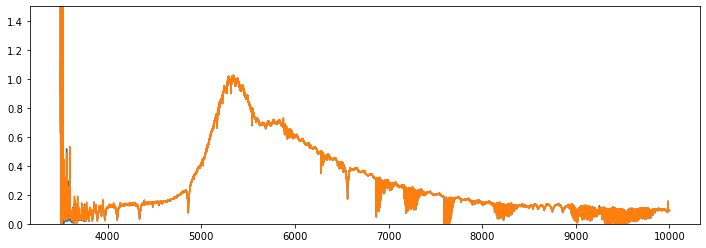

In [26]:
starflatcomb=wav.scomb(test,wnew,average=True,usemask=True)

# raw / flat averaged
plt.figure(figsize=(12,4))
data=starflatcomb.data
plt.plot(wnew,data/(np.nanmax(median_filter(data[20000:50000],[500]))))
data=starcomb.data/flatcomb.data
plt.plot(wnew,data/np.nanmax(median_filter(data[20000:50000],[500])))
plt.ylim(0,1.5)

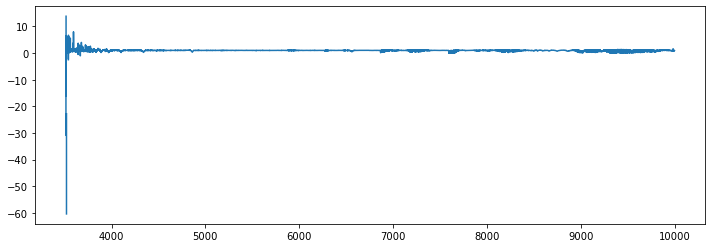

In [27]:
plt.figure(figsize=(12,4))
plt.plot(wnew,data/median_filter(data,[2000]))

<h3> Batch reduction

In [28]:
from pyvista import reduce
fig=plt.figure()
reduce.all('oct21.yml',groups='ARCES',display=None,plot=fig)

FileNotFoundError: [Errno 2] No such file or directory: 'oct21.yml'

<Figure size 432x288 with 0 Axes>